<a href="https://colab.research.google.com/github/devamsheth21/Bearing-Fault-Detection-using-Deep-Learning-approach/blob/main/classification_sdp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
!nvidia-smi

Sun Oct 24 09:36:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
data_dir = "/content/gdrive/MyDrive/MP(Inner-Outer)"
Categories = [ "Inner","Outer"]


In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/gdrive/MyDrive/MP(Inner-Outer)')

In [ ]:
list(data_dir.glob('*/*.png'))[:5]

[PosixPath('/content/gdrive/MyDrive/MP(Inner-Outer)/Outer/OR007@12_03.png'),
 PosixPath('/content/gdrive/MyDrive/MP(Inner-Outer)/Outer/OR007@12_05.png'),
 PosixPath('/content/gdrive/MyDrive/MP(Inner-Outer)/Outer/OR007@12_07.png'),
 PosixPath('/content/gdrive/MyDrive/MP(Inner-Outer)/Outer/OR007@12_02.png'),
 PosixPath('/content/gdrive/MyDrive/MP(Inner-Outer)/Outer/OR007@12_04.png')]

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1213


In [ ]:
Inner = list(data_dir.glob('Inner/*'))
Inner[:5]
Outer = list(data_dir.glob('Outer/*'))

In [ ]:
# PIL.Image.open(str(Healthy[6]))

In [ ]:
# PIL.Image.open(str(Faulty[9]))

In [ ]:
'''from google.colab.patches import cv2

X, y = [], []
i=0

for category, images in images_dict.items():
  for image in images:
    print(i)
    i+=1

    img = cv2.imread(str(image))
    img = img[0:288, 72:360, :]

  X.append(img)
  y.append(category_dict[category])'''

In [ ]:
batch_size = 32
img_height = 288
img_width = 288

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2508 files belonging to 2 classes.
Using 2007 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 2508 files belonging to 2 classes.
Using 501 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Faulty', 'Healthy']


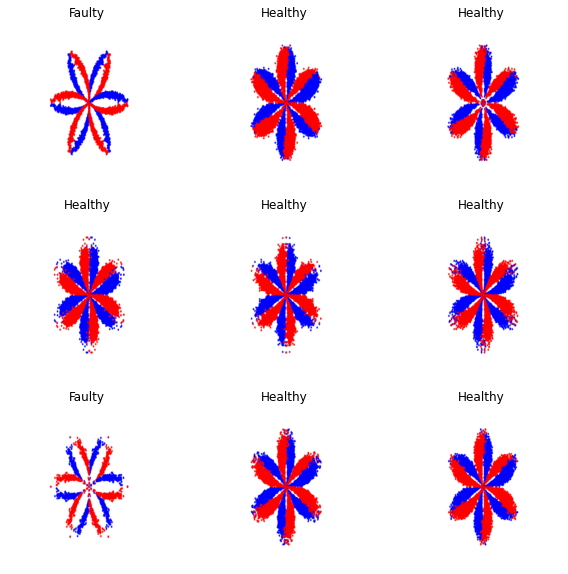

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i],axis=0)])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 288, 288, 3)
(32, 2)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

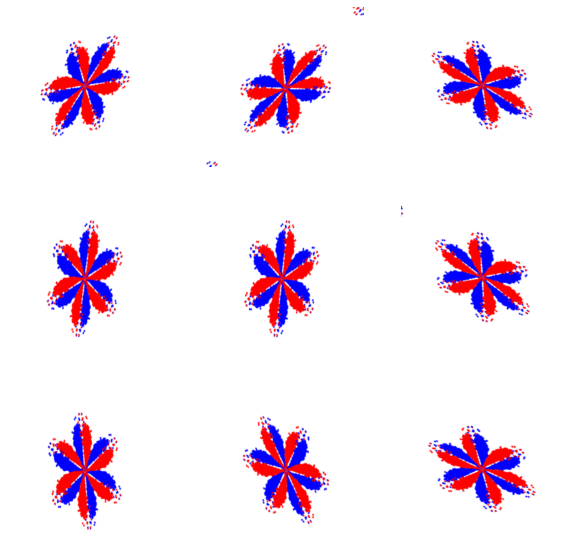

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
from tensorflow.keras import layers


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)


In [ ]:
num_classes = 2
model = Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),                  
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(288,288,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(2,activation="sigmoid")
])

In [ ]:
model.compile(optimizer='adam',
                   loss=tf.keras.losses.categorical_crossentropy,
                   metrics=['accuracy'])

In [ ]:
model.fit(train_ds, validation_data=val_ds,epochs=5)

Epoch 1/5
63/63 [==============================] - 357s 5s/step - loss: 0.3475 - accuracy: 0.9407 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
63/63 [==============================] - 12s 177ms/step - loss: 1.0751e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
63/63 [==============================] - 12s 177ms/step - loss: 1.2473e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 12s 179ms/step - loss: 4.1576e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 12s 177ms/step - loss: 2.4353e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 288, 288, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 288, 288, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 144, 144, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 144, 144, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)       

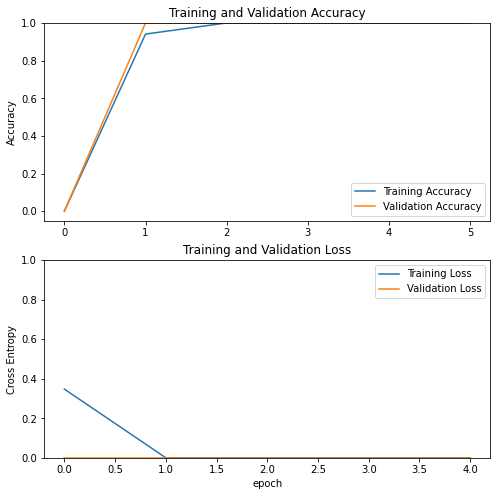

In [ ]:
acc = [0.] + model.history.history['accuracy']
val_acc = [0.] + model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(288,288))
    
    plt.imshow(img1)
 
    x = image.img_to_array(img1)
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    val = model.predict(x)
    print(val)
    if val < 0.5:
        
        plt.xlabel("F",fontsize=30)
        
    
    else:
        
        plt.xlabel("H",fontsize=30)
       

In [ ]:
predictImage(r"/content/gdrive/MyDrive/Classification/Faulty/0R007@6_10.png")

In [ ]:
predictImage(r"/content/gdrive/MyDrive/Classification/Faulty/IR007_2_40.png")

In [ ]:
# category_dict={"Healthy":0,"Faulty":1}
# images_dict = {"Healthy" : Healthy,"Faulty" : Faulty}

In [ ]:
# img = cv2.imread(str(images_dict["Faulty"][1]))
# img.shape

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(str(images_dict["Faulty"][1]))
crop_img = img[0:288, 72:360, :]

cv2_imshow( crop_img)
print(crop_img.shape)

In [ ]:
# from google.colab.patches import cv2

# X, y = [], []
# i=0

# for category, images in images_dict.items():
#     for image in images:
#       print(i)
#       i+=1

#       img = cv2.imread(str(image))
#       img = img[0:288, 72:360, :]

#       X.append(img)
#       y.append(category_dict[category])

In [ ]:
# X = np.array(X)
# y = np.array(y)

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# len(X_train)

In [ ]:
# from PIL import Image
# img = Image.fromarray(X_train[0], 'RGB')
# img.show()


In [ ]:
# X_train_scaled = X_train / 255
# X_test_scaled = X_test / 255

In [ ]:
num_classes = 2
model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu',input_shape=(288,288,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1,activation="sigmoid")
])

In [ ]:

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train_scaled, y_train,steps_per_epoch=33,epochs=5, validation_data=(X_test_scaled, y_test))

In [ ]:
model.evaluate(X_test_scaled,y_test)

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.preprocessing import image
